Social Media and Network Analytics
Assignment 2: Analysing and Tracking the Sentiment and Topics on Social Media Reddit and YouTube

"ANALYZING THE CHALLENGES ENCOUNTERED BY INTERNATIONAL STUDENTS VIA SOCIAL MEDIA ENGAGEMENT  (YouTube)"

Reddit(data analysis)



# Sentiment Analysis using word count

In [2]:
from redditClient import redditClient
import praw
import json
import sys
import string
from collections import Counter
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
import codecs
import re
import math
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from colorama import Fore, Back, Style
import datetime
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from colorama import Fore, Back, Style
import pandas as pd
from datetime import datetime
from country_list import countries_for_language
from RedditProcessing import RedditProcessing
import networkx as nx
from matplotlib.patches import ArrowStyle
import random
from twarc import Twarc

[nltk_data] Downloading package stopwords to C:\Users\Aishwarya
[nltk_data]     C\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Aishwarya
[nltk_data]     C\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
%load_ext autoreload
%autoreload 1
%aimport RedditProcessing

C:\Users\Aishwarya C\anaconda3\lib\site-packages\IPython\extensions\autoreload.py:121: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [4]:
def computeSentiment(lTokens, setPosWords, setNegWords):

    # counting the number of positive words (hint: use setPosWords)
    poswordCount = 0
    for word in lTokens:
        if word in setPosWords:
            poswordCount += 1
    
    # counting the number of negative words (hint: use setNegWords)
    negwordCount = 0
    for word in lTokens:
        if word in setNegWords:
            negwordCount += 1
            
    # computing the sentiment 
    numberPosWords = poswordCount
    numberNegWords = negwordCount
    sentimentValue = numberPosWords - numberNegWords
    
    # computing the sentiment value
    sentiment = sentimentValue
    
    return sentiment


In [5]:
def printColouredTokens(lTokens, setPosWords, setNegWords, sentiment):
    for token in lTokens:
        if token in setPosWords:
            print(Fore.RED + token + ', ', end='')
        elif token in setNegWords:
            print(Fore.BLUE + token + ', ', end='')
        else:
            print(Style.RESET_ALL + token + ', ', end='')

    print(': {}'.format(sentiment))
    

In [6]:
def countWordSentimentAnalysis(setPosWords, setNegWords, sTweetsFilename, bPrint, redditProcessor):

    lSentiment = []
    # open file and process reddit submissions and comments, one by one
    with open('international_students_cleaned.json', 'r') as f:
        redditDump = [json.loads(line) for line in f]
        
        for submission in redditDump:
            postText = submission['title']
            postDate = submission['created']
            
            # pre-process the reddit post text
            lTokens = redditProcessor.process(postText)
            lTokens = [token for token in lTokens if token.encode('utf-8').isalpha()]
            
            # computing sentiment 
            sentiment = computeSentiment(lTokens, setPosWords, setNegWords)
                
            # save the date and sentiment of each reddit post (used for time series)
            lSentiment.append([(postDate), sentiment])

            # red is printed for positive and blue color for negative words
            if bPrint:
                printColouredTokens(lTokens, setPosWords, setNegWords, sentiment)
                
            # processing the comments
            for comment in submission['comments']:
                postText = comment['body']
                postDate = comment['created_utc']
                
                # pre-process the tweet text
                lTokens = redditProcessor.process(postText)
                lTokens = [token for token in lTokens if token.encode('utf-8').isalpha()]
            
                # computing sentiment 
                sentiment = computeSentiment(lTokens, setPosWords, setNegWords)
                
                # save the date and sentiment of each tweet
                lSentiment.append([(postDate), sentiment])

               
                if bPrint:
                    printColouredTokens(lTokens, setPosWords, setNegWords, sentiment)


    return lSentiment


# Sentiment Analysis using Vader approach

In [7]:
def vaderPrintTokens(lTokens, dSentimentScores):

    print(*lTokens, sep=', ')
    for cat,score in dSentimentScores.items():
        print('{0}: {1}, '.format(cat, score), end='')
    print()

In [8]:
def vaderSentimentAnalysis(sTweetsFilename, bPrint, tweetProcessor):

    # this is the vader sentiment analyser, part of nltk
    sentAnalyser = SentimentIntensityAnalyzer()


    lSentiment = []
    # open file and process tweets, one by one
    with open(sTweetsFilename, 'r') as f:
        redditDump = [json.loads(line) for line in f]
        
        for submission in redditDump:
            postText = submission['title']
            postDate = submission['created']
            
            # pre-process the post text
            lTokens = redditProcessor.process(postText)

            # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
            # see workshop sheet for what dSentimentScores holds
            dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

            # save the date and sentiment of each post (used for time series)
           
            
            compound = dSentimentScores['compound']
            positive = dSentimentScores['pos']
            negative = dSentimentScores['neg']
            neutral = dSentimentScores['neu']
            lSentiment.append([(postDate), compound, positive, negative, neutral,lTokens])


            # if we are printing, we print the tokens then the sentiment scores.  Because we don't have the list
            # of positive and negative words, we cannot use colorama to label each token
            if bPrint:
                vaderPrintTokens(lTokens, dSentimentScores)
                
                
            # process the comments
            for comment in submission['comments']:
                postText = comment['body']
                postDate = comment['created_utc']
                
                # pre-process the post text
                lTokens = redditProcessor.process(postText)

                # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
                # see workshop sheet for what dSentimentScores holds
                dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

                # save the date and sentiment of each post 
                compound = dSentimentScores['compound']
                positive = dSentimentScores['pos']
                negative = dSentimentScores['neg']
                neutral = dSentimentScores['neu']
                lSentiment.append([(postDate), compound, positive, negative, neutral,lTokens])


                # if we are printing, we print the tokens then the sentiment scores.  Because we don't have the list
                # of positive and negative words, we cannot use colorama to label each token
                if bPrint:
                    vaderPrintTokens(lTokens, dSentimentScores)
                    
                    
    return lSentiment

# Positive words and negative words text file used to compare and positive and negative words

In [9]:
# input file of set of postive words
posWordFile = 'positive-words.txt'
# input file of set of negative words
negWordFile = 'negative-words.txt'
# input file of set of reddit posts (json format)
redditFile = 'intl_stud_cleaned.json'
# flag to determine whether to print out tweets and their sentiment
flagPrint = True
# specify the approach to take, one of [count, vader]
# change this to use a different sentiment approach
approach = 'count'

In [10]:
# construct the reddit pro-processing object
# use tweet tokenizer
tweetTokenizer =  nltk.tokenize.TweetTokenizer()
lPunct = list(string.punctuation)
# standard 'English' stopwords plus we want to remove things like 'rt' (retweet) etc
lStopwords =  nltk.corpus.stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`']

# call the RedditProcessing python script
redditProcessor = RedditProcessing.RedditProcessing(tweetTokenizer, lStopwords)


# load set of positive words
lPosWords = []
with open(posWordFile, 'r', encoding='utf-8', errors='ignore') as fPos:
    for sLine in fPos:
        lPosWords.append(sLine.strip())

setPosWords = set(lPosWords)


# load set of negative words
lNegWords = []
with codecs.open(negWordFile, 'r', encoding='utf-8', errors='ignore') as fNeg:
    for sLine in fNeg:
        lNegWords.append(sLine.strip())

setNegWords = set(lNegWords)

### Calling the count approach method and calculating positive,negative and neutral sentiments

In [11]:
pos_count=[]
neg_count=[]
neu_count=[]
print("********************************Count Approach****************************************")
lSentiment_count= countWordSentimentAnalysis(setPosWords, setNegWords, redditFile, flagPrint, redditProcessor)

# Count of positive,negative and neutral sentiments
for sent_count in lSentiment_count:
    score=sent_count[1]
    if score >1:
        pos_count.append(1)
    elif score<1:
        neg_count.append(1)
    else:
        neu_count.append(1)
    

********************************Count Approach****************************************
program, australia, bsn, consid, intern, enrol, student, : 0
position, last, year, ideal, considering, much, opportunities, australia, especially, comes, medical, field, also, ph, : 1
well, first, really, sure, going, year, ago, applied, different, schools, ph, australia, applied, rmit, later, sent, offer, letter, began, process, stuff, really, use, agents, since, expensive, went, throught, process, documents, needed, along, family, sorry, helpful, want, questions, send, pm, : 0
friend, languag, get, intern, student, foreign, : 0
got, situation, started, studying, abroad, pushing, joining, clubs, org, getting, involved, campus, like, going, events, people, know, foreign, country, expect, fluent, language, feel, free, make, mistakes, improve, one, thing, really, helpful, honest, friends, get, say, pretend, like, understand, say, ask, explain, explain, friends, conscious, fact, different, country, star

### Calling the Vader approach and calculating positive, negative and neutral sentiments .

In [12]:
pos_val=[]
neg_val=[]
neu_val=[]
min_comp=0.0
approach = 'vader'

print("********************************Vader Approach*****************************************")
lSentiment_vader= vaderSentimentAnalysis(redditFile, flagPrint, redditProcessor)


# Count of positive,negative and neutral sentiments
for sent in lSentiment_vader:
    comp=sent[1]
    if comp > 0.0:
        pos_val.append(1)
    elif comp < 0.0:
        neg_val.append(1)
    elif comp == 0.0:
        neu_val.append(1)

#Identifying the highest negative sentiment
for i in lSentiment_vader:
    comp1=i[1]
    if comp1<min_comp:
        min_comp=comp1
    else:
        min_comp
for s in lSentiment_vader:
    if s[1]== min_comp:
        print(s)

        
        


********************************Vader Approach*****************************************
look, draft, review, could, offic, context, femal, relev, prepar, intend, chanc, intern, someon, send, germani, email, happi, author, plea, share, text
neg: 0.0, neu: 0.901, pos: 0.099, compound: 0.296, 
way, long, complicated, international, office, reads, bit, like, chat, gpt, actually, would, send, much, shorter, email, simply, outlining, questions, admissions, process, leave, personal, information, background, makes, difference, apply, show, qualifications, experience, time, share, personal, information, international, office, need, know, simple, email, regarding, application, processes, likely, direct, admissions, pages, website, though, want, specific, information, particularly, regarding, academics, specifics, programme, want, apply, would, make, questions, much, clearer, email, send, relevant, department, never, heard, university, looking, specific, qualities, attributes, international, stud

In [13]:
# Generating a dictionary for word count approach and vader approach

word_dict={'positive':len(pos_count),'negative':len(neg_count),'neutral':len(neu_count)}
print("-----------Word_count_approach-----------------")
print(word_dict)
print(" ")

vader_dict ={'positive':len(pos_val),'negative':len(neg_val),'neutral':len(neu_val)}
print("-----------Vader approach----------------------")
print(vader_dict)

-----------Word_count_approach-----------------
{'positive': 238, 'negative': 1153, 'neutral': 300}
 
-----------Vader approach----------------------
{'positive': 638, 'negative': 101, 'neutral': 513}


In [14]:
# lSentiment_vader contains a list of lists with sentiment data
# Each sublist contains [postDate, compound, positive, negative, neutral, lTokens]

# Sort the list by the 'positive' score in descending order
pos_sentiment = sorted(lSentiment_vader, key=lambda x: x[2], reverse=True)
neg_sentiment = sorted(lSentiment_vader, key=lambda x: x[3], reverse=True)

# Get the top 10 positive sentiment scores

sentiment_posts = []



for pos in pos_sentiment:
    postDate, compound, positive, negative, neutral, lTokens = pos
    sentiment_posts.append({
        'Date': postDate,
        'Positive Score': positive,
        'Tokens': lTokens  
    })
for neg in neg_sentiment:
    postDate, compound, positive, negative, neutral, lTokens = neg
    sentiment_posts.append({
        'Date': postDate,
        'Negative Score': negative,
        'Tokens': lTokens  
    })




In [15]:
from country_list import countries_for_language

country_list = countries_for_language('en')
extracted_countries = {}  # Create a dictionary to store country information
country_names = {country[1].lower() for country in country_list}

for post in sentiment_posts:
    tokens = post.get('Tokens', [])  # Get the 'Tokens' value from the dictionary or an empty list if it doesn't exist
    pos = post.get('Positive Score', 0)  # Initialize to 0 if not present
    neg = post.get('Negative Score', 0)  # Initialize to 0 if not present
    
    for token in tokens:
        if token in country_names:
            if token in extracted_countries:
                # If the country token already exists, update the positive and negative scores
                extracted_countries[token]['Positive score'] += pos
                extracted_countries[token]['Negative score'] += neg
            else:
                # If the country token is not in extracted_countries, create a new entry
                extracted_countries[token] = {'Positive score': pos, 'Negative score': neg}

print(extracted_countries)
                

{'germany': {'Positive score': 15.31199999999999, 'Negative score': 2.512000000000001}, 'belgium': {'Positive score': 2.631, 'Negative score': 0.264}, 'canada': {'Positive score': 7.535999999999999, 'Negative score': 2.2230000000000003}, 'spain': {'Positive score': 6.186000000000001, 'Negative score': 1.9829999999999999}, 'thailand': {'Positive score': 1.324, 'Negative score': 0.0}, 'france': {'Positive score': 6.377, 'Negative score': 1.4519999999999995}, 'japan': {'Positive score': 6.494, 'Negative score': 0.557}, 'switzerland': {'Positive score': 1.826, 'Negative score': 0.131}, 'singapore': {'Positive score': 1.7650000000000001, 'Negative score': 0.666}, 'sweden': {'Positive score': 2.707, 'Negative score': 0.19}, 'ireland': {'Positive score': 2.600000000000001, 'Negative score': 0.19599999999999998}, 'netherlands': {'Positive score': 6.464000000000003, 'Negative score': 1.008}, 'georgia': {'Positive score': 0.412, 'Negative score': 0.0}, 'turkey': {'Positive score': 0.412, 'Negati

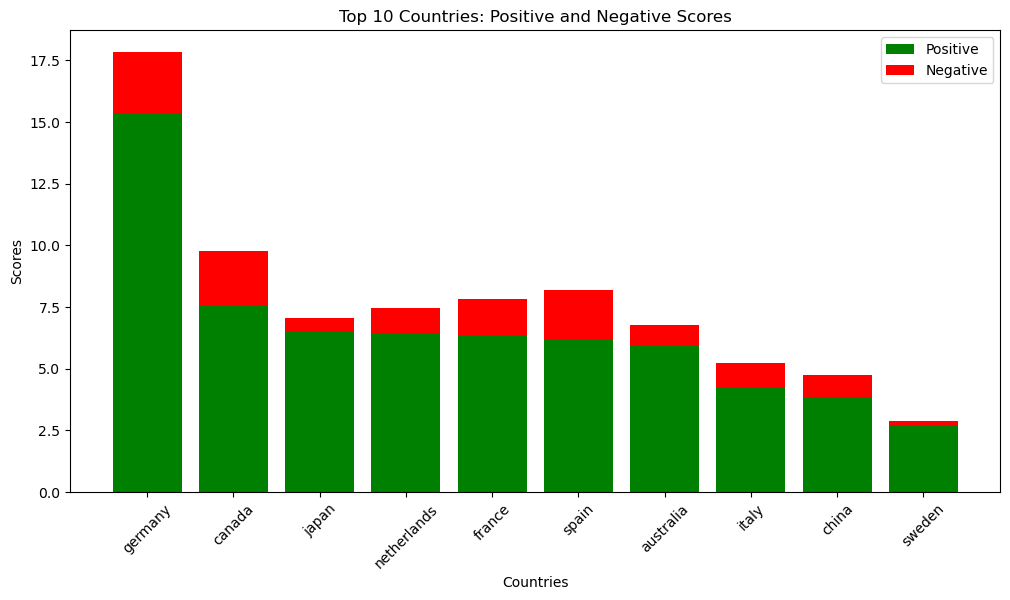

In [16]:

# Sort the countries by positive scores in descending order and take the top 10
top_10_countries = sorted(extracted_countries.keys(), key=lambda x: extracted_countries[x]['Positive score'], reverse=True)[:10]

# Extract the top 10 countries and their scores
top_10_positive_scores = [extracted_countries[country]['Positive score'] for country in top_10_countries]
top_10_negative_scores = [extracted_countries[country]['Negative score'] for country in top_10_countries]


plt.figure(figsize=(12, 6))

plt.bar(top_10_countries, top_10_positive_scores, label='Positive', color='g')
plt.bar(top_10_countries, top_10_negative_scores, bottom=top_10_positive_scores, label='Negative', color='r')

plt.xlabel('Countries')
plt.ylabel('Scores')
plt.title('Top 10 Countries: Positive and Negative Scores')
plt.legend()

plt.xticks(rotation=45) 

plt.show()


<Figure size 10000x5500 with 0 Axes>

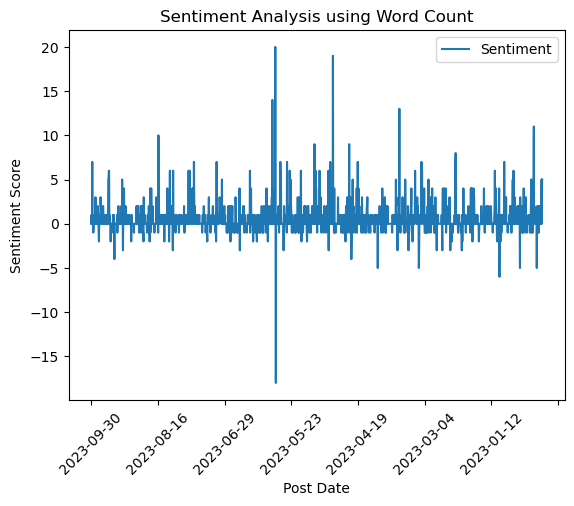

In [17]:
## Word count approach across time period

plt.figure(figsize=(100, 55)) 
series = pd.DataFrame(lSentiment_count, columns=['Date', 'Sentiment'])
series.set_index('Date', inplace=True)
series[['Sentiment']] = series[['Sentiment']].apply(pd.to_numeric)
series.plot()
plt.xlabel("Post Date")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis using Word Count")
plt.xticks(rotation=45)
plt.show()


<Figure size 10000x5500 with 0 Axes>

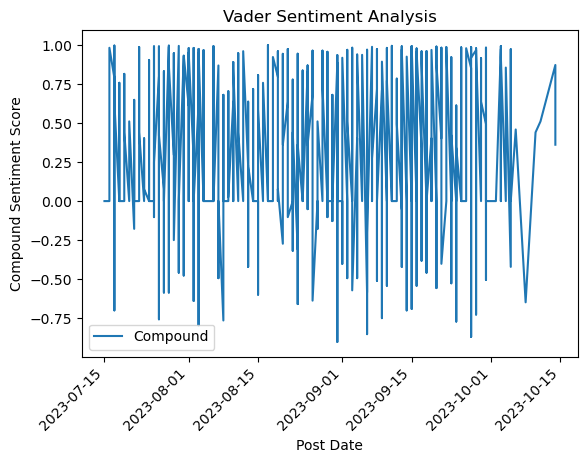

In [18]:
## Word count approach across time period


lSentiment_vader_filtered = [[sentiment[0], sentiment[1]] for sentiment in lSentiment_vader]

plt.figure(figsize=(100, 55))
series = pd.DataFrame(lSentiment_vader_filtered, columns=['Date', 'Compound'])
series['Date'] = pd.to_datetime(series['Date'])
series.set_index('Date', inplace=True)
series[['Compound']] = series[['Compound']].apply(pd.to_numeric)
series.plot()
plt.xlabel("Post Date")
plt.ylabel("Compound Sentiment Score")
plt.title("Vader Sentiment Analysis")
plt.xticks(rotation=45)
plt.show()


## Topic Analysis

## LDA Model

In [19]:
# number of topics to discover (default = 10)
topicNum = 5
# maximum number of words to display per topic (default = 10)
wordNumToDisplay = 15
# this is the number of features/words to used to describe our documents
featureNum = 1500

In [20]:
with open('international_students_cleaned.json', 'r', encoding='utf-8') as f:
    cleaned_sub = [json.loads(line) for line in f]

nt = [submission['title'] for submission in cleaned_sub]

# Count Vectorizer
tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(nt)
# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()
# LDA MODEL
# Run LDA
ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

## Coherence score

C:\Users\Aishwarya C\anaconda3\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


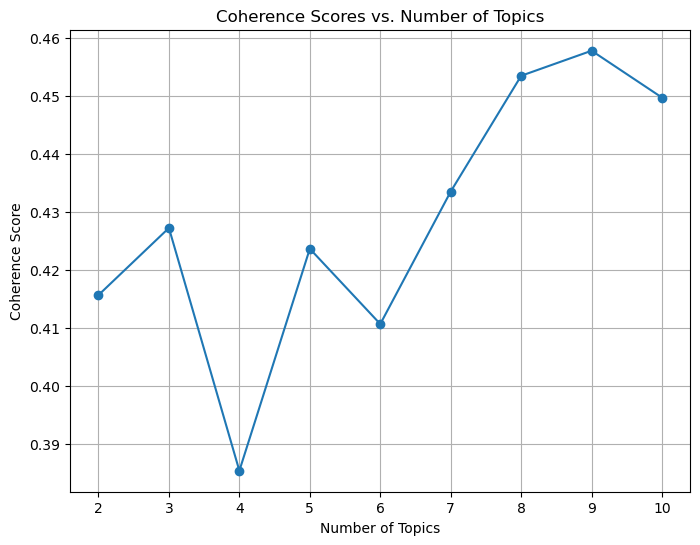

In [21]:
import json
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Load and preprocess your text data
with open('international_students_cleaned.json', 'r', encoding='utf-8') as f:
    cleaned_sub = [json.loads(line) for line in f]
nt = [submission['title'] for submission in cleaned_sub]

# Tokenize the text and create a Gensim Dictionary and Corpus
texts = [text.split() for text in nt]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Define a range of topic numbers to evaluate
topic_range = range(2, 11)  # You can adjust the range as needed

# Initialize an empty list to store coherence scores
coherence_scores = []

# Loop through different topic numbers and calculate coherence scores
for num_topics in topic_range:
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10,random_state=42)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append((num_topics, coherence_score))

# Extract the topic numbers and coherence scores
topic_numbers, scores = zip(*coherence_scores)

# Create a graph to visualize coherence scores
plt.figure(figsize=(8, 6))
plt.plot(topic_numbers, scores, marker='o')
plt.title('Coherence Scores vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.show()


## Topic Visualization

In [22]:
# number of topics to discover (default = 10)
topicNum = 9
# maximum number of words to display per topic (default = 10)
wordNumToDisplay = 15
# this is the number of features/words to used to describe our documents
featureNum = 1500

In [23]:
with open('international_students_cleaned.json', 'r', encoding='utf-8') as f:
    cleaned_sub = [json.loads(line) for line in f]

nt = [submission['title'] for submission in cleaned_sub]

# Count Vectorizer
tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(nt)
# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()
# LDA MODEL
# Run LDA
ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

In [24]:
def display_topics(model, featureNames, numTopWords):
      # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [25]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
tip ielt write mind understand relationship issu medic world work transfer test listen admiss open
Topic 1:
student intern studi usa visa canada graduat job year good look want scholarship abroad start
Topic 2:
opt work cpt permit question franc post opportun internship summer life ielt visa recommend day
Topic 3:
help need survey english univ anyon academ suggest experi mba uni studi speak tell tutor
Topic 4:
univ loan offer student germani educ requir worth languag privat differ new canadian letter state
Topic 5:
job think opt feel know anyon commun major tax help tri process plea stem fund
Topic 6:
advic insur appli health visa countri month home come choo option vs seek hou car
Topic 7:
master canada bachelor plan school travel degr high program licen anyon guy driver deal wonder
Topic 8:
colleg need research scholarship program pay expir help sevi visa urgent mental fee chang particip


## Word cloud

In [26]:
import numpy as np
def displayWordcloud(model, featureNames):
    # this normalises each row/topic to sum to one
    # use this normalisedComponents to display your wordclouds
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]    
    topicNum = len(model.components_)
    # number of wordclouds for each row
    plotColNum = 3
    # number of wordclouds for each column
    plotRowNum = int(math.ceil(topicNum / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.show(block=True)

C:\Users\Aishwarya C\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\Aishwarya C\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\Aishwarya C\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\Aishwarya C\anaconda3\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation

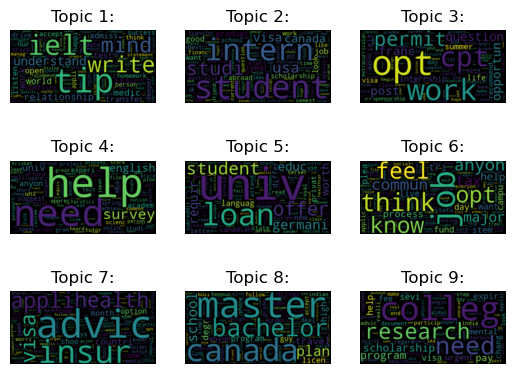

In [27]:
# display wordcloud
displayWordcloud(ldaModel, tfFeatureNames)

### pyLDAvis

In [28]:
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

C:\Users\Aishwarya C\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Aishwarya C\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


## Graph Modelling

In [29]:
# Load data from the JSON file
data = []

with open("international_students_cleaned.json", "r") as f:
    for line in f:
        data.append(json.loads(line))
        
G = nx.DiGraph()


In [30]:
counter = 0
# Iterate through the data
for post in data:
    author = post['author']
    comments = post['comments']
    if author:
        G.add_node(author)
        for comment in comments:
            comment_author = comment['author']
            if comment_author:
                G.add_node(comment_author)
                G.add_edge(author, comment_author)
    counter = counter + 1
    if counter >= 50:
        break;

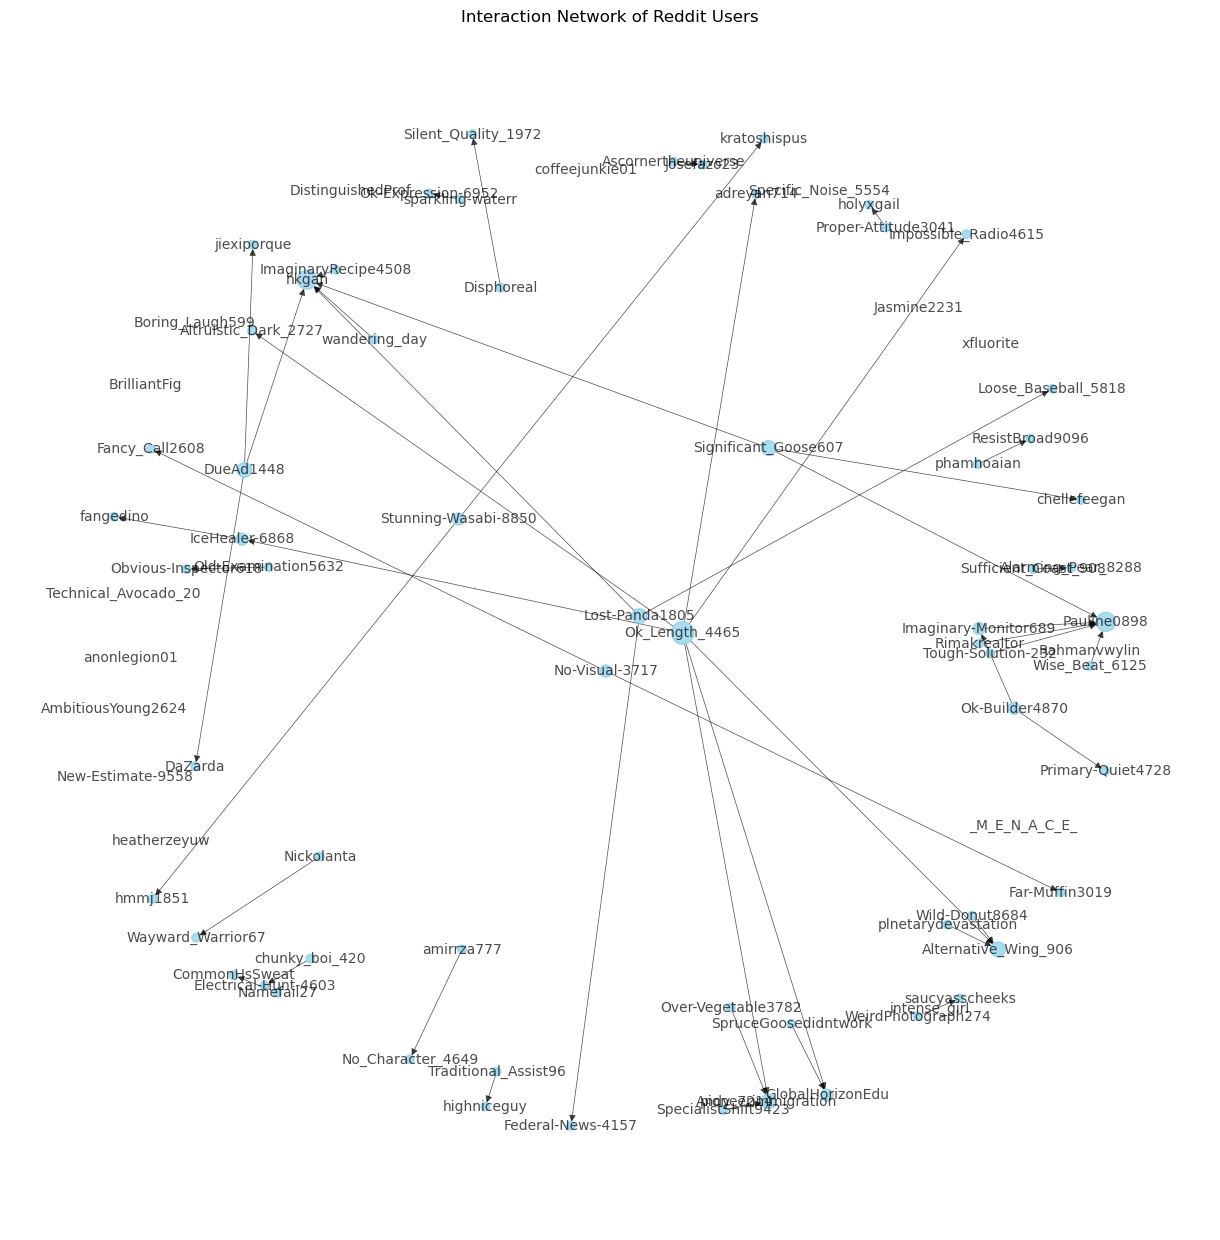

In [31]:
# Compute degree centrality
degree_centrality = nx.degree_centrality(G)

# Identify influential users with high degree centrality
influential_users = [node for node, centrality in degree_centrality.items() if centrality > 0.1]

# Customize the node size based on degree centrality
node_sizes = [3000 * degree_centrality[node] for node in G.nodes()]

# Set a more readable layout
pos = nx.spring_layout(G, k=0.15)

# Draw the graph with improved readability
plt.figure(figsize=(12, 12))  # Adjust the figure size
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', font_size=10, font_color='black', alpha=0.7, width=0.5)
plt.title("Interaction Network of Reddit Users")
plt.axis('off')  # Turn off axis
plt.show()

# By following these steps, you can identify unique Reddit user names in your data and create nodes for each user in your network graph. This network representation will allow you to perform further network analysis, such as community detection, centrality measures, and more, to gain insights into user interactions related to international student topics on Reddit.

## Reply Graph

In [33]:
# Initialize an empty graph
replyGraph = nx.Graph()

# Create dictionaries for submission comments
dSubCommentId = {}

# Open the JSON file for reading
with open('international_students_cleaned.json', 'r') as file:
    # Read the file line by line
    for line in file:
        # Parse each line as a JSON object
        data = json.loads(line)

        author_name = data.get('author', None)
        submission_id = data.get('submission_id', None)

        if author_name:
            if author_name in replyGraph:
                replyGraph.nodes[author_name]['subNum'] += 1
            else:
                replyGraph.add_node(author_name, subNum=1)

            if submission_id:
                dSubCommentId[submission_id] = {submission_id: author_name}

            comments = data.get('comments', [])
            for comment in comments:
                comment_author = comment.get('author', None)
                comment_id = comment.get('comment_id', None)
                parent_id = comment.get('parent_id', None)

                if comment_author and comment_author != 'ExternalUserError':
                    if submission_id and comment_id:
                        dSubCommentId[submission_id].update({comment_id: comment_author})

                    if parent_id in dSubCommentId.get(submission_id, {}):
                        if replyGraph.has_edge(comment_author, dSubCommentId[submission_id][parent_id]):
                            replyGraph[comment_author][dSubCommentId[submission_id][parent_id]]['replyNum'] += 1
                        else:
                            if comment_author not in replyGraph:
                                replyGraph.add_node(comment_author, subNum=0)

                            if dSubCommentId[submission_id][parent_id] not in replyGraph:
                                replyGraph.add_node(dSubCommentId[submission_id][parent_id], subNum=0)

                            replyGraph.add_edge(comment_author, dSubCommentId[submission_id][parent_id], replyNum=1)

# Print the nodes in the graph
print(replyGraph.nodes)

# TODO: Save the graph to a file
sFileName = "replyGraph.graphml"
nx.readwrite.write_graphml(replyGraph, sFileName)


['Old-Examination5632', 'sparkling-waterr', 'Ok-Builder4870', 'Namefail27', 'heatherzeyuw', 'Stunning-Wasabi-8850', 'Rahmanvwylin', 'Over-Vegetable3782', 'Wise_Beat_6125', 'Imaginary-Monitor689', 'Rimakrealtor', 'coffeejunkie01', 'SpruceGoosedidntwork', 'Significant_Goose607', 'Lost-Panda1805', 'Ok_Length_4465', 'wandering_day', 'xfluorite', 'Technical_Avocado_20', 'amirrza777', 'DueAd1448', 'BrilliantFig', 'Tough-Solution-232', 'IceHealer-6868', 'Nickolanta', 'plnetarydevastation', 'Disphoreal', 'SpecialistShift9423', 'Wild-Donut8684', 'No-Visual-3717', 'Primary-Quiet4728', 'Andy_7214', 'phamhoaian', 'Traditional_Assist96', 'AmbitiousYoung2624', 'chunky_boi_420', 'ImaginaryRecipe4508', 'Specific_Noise_5554', 'Proper-Attitude3041', 'Jasmine2231', 'Ascornertheuniverse', 'intense_girl', 'anonlegion01', 'Sufficient_Coast_908', 'DistinguishedProf', 'Boring_Laugh599', 'WeirdPhotograph274', 'New-Estimate-9558', '_M_E_N_A_C_E_', 'FlickerrHoney', 'EFUAS-com', 'ExchangeEmotional252', 'teletubby

In [34]:
print(replyGraph.nodes)

['Old-Examination5632', 'sparkling-waterr', 'Ok-Builder4870', 'Namefail27', 'heatherzeyuw', 'Stunning-Wasabi-8850', 'Rahmanvwylin', 'Over-Vegetable3782', 'Wise_Beat_6125', 'Imaginary-Monitor689', 'Rimakrealtor', 'coffeejunkie01', 'SpruceGoosedidntwork', 'Significant_Goose607', 'Lost-Panda1805', 'Ok_Length_4465', 'wandering_day', 'xfluorite', 'Technical_Avocado_20', 'amirrza777', 'DueAd1448', 'BrilliantFig', 'Tough-Solution-232', 'IceHealer-6868', 'Nickolanta', 'plnetarydevastation', 'Disphoreal', 'SpecialistShift9423', 'Wild-Donut8684', 'No-Visual-3717', 'Primary-Quiet4728', 'Andy_7214', 'phamhoaian', 'Traditional_Assist96', 'AmbitiousYoung2624', 'chunky_boi_420', 'ImaginaryRecipe4508', 'Specific_Noise_5554', 'Proper-Attitude3041', 'Jasmine2231', 'Ascornertheuniverse', 'intense_girl', 'anonlegion01', 'Sufficient_Coast_908', 'DistinguishedProf', 'Boring_Laugh599', 'WeirdPhotograph274', 'New-Estimate-9558', '_M_E_N_A_C_E_', 'FlickerrHoney', 'EFUAS-com', 'ExchangeEmotional252', 'teletubby

In [35]:
sFileName = "replyGraph.graphml"

In [36]:
# read it back in to demonstrate it works
replyGraph = nx.readwrite.read_graphml(sFileName)


# computing the degree centrality and plotting it
lDegCentrality = nx.degree_centrality(replyGraph)


#
# TODO: write code to compute eigenvetor and katz centrality
# lEigenVectorCentrality = ...
#
lEigenVectorCentrality = nx.eigenvector_centrality(replyGraph)
lKatzCentrality = nx.katz_centrality(replyGraph)


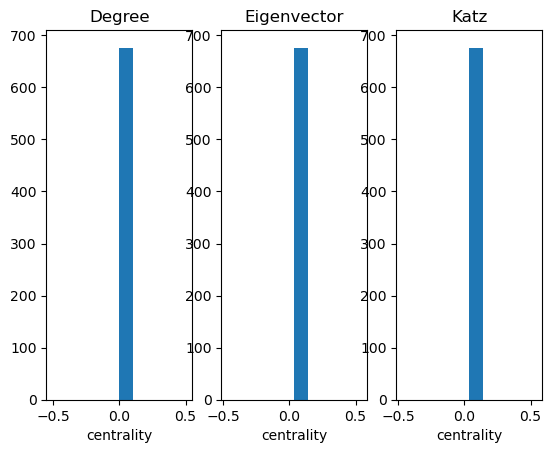

In [37]:
# plot histograms
plt.subplot(1,3,1)
plt.hist(list(lDegCentrality.values()))
plt.title('Degree')
plt.xlabel('centrality')
#
# TODO: plot the other two histograms
#
# eigenvector centrality
plt.subplot(1, 3, 2)
plt.hist(list(lEigenVectorCentrality.values()))
plt.title('Eigenvector')
plt.xlabel('centrality')
# katz centrality
plt.subplot(1, 3, 3)
plt.hist(list(lKatzCentrality.values()))
plt.title('Katz')
plt.xlabel('centrality')

plt.show()

## Identifying most popular accounts based on centrality score

In [38]:
for nodeId, cent in lEigenVectorCentrality.items():
    replyGraph.nodes[nodeId]['eigen'] = float(cent)

In [39]:
for nodeId, cent in lKatzCentrality.items():
    replyGraph.nodes[nodeId]['katz'] = float(cent)

In [40]:

nx.readwrite.write_graphml(replyGraph, 'mod' + sFileName, infer_numeric_types=True)


In [41]:


# Load the graph from the GraphML file
replyGraph = nx.readwrite.read_graphml(sFileName)

# Make a copy of the original graph
copiedGraph = replyGraph.copy()



In [42]:
copiedGraph = nx.DiGraph()  # Create a directed graph
copiedGraph.add_nodes_from(replyGraph.nodes(data=True))
copiedGraph.add_edges_from(replyGraph.edges(data=True))

In [43]:



print('Gloabl clustering coefficient/transitivit = {}'.format(nx.transitivity(copiedGraph)))


#
# compute components
#
print('number of strongly connected components = {}'.format(nx.number_strongly_connected_components(copiedGraph)))
print('number of weakly connected components = {}'.format(nx.number_weakly_connected_components(copiedGraph)))



#
# compute bridges
#
print(list(nx.bridges(copiedGraph.to_undirected())))

Gloabl clustering coefficient/transitivit = 0
number of strongly connected components = 676
number of weakly connected components = 676
[]


In [44]:

# Load your graph from the modified GraphML file (mod + sFileName)
replyGraph = nx.readwrite.read_graphml('mod' + sFileName)

# Calculate the centrality measures (degree, eigenvector, Katz centrality)
lDegCentrality = nx.degree_centrality(replyGraph)
lEigenVectorCentrality = nx.eigenvector_centrality(replyGraph)
lKatzCentrality = nx.katz_centrality(replyGraph)

# Combine all centrality scores into a single dictionary
all_centrality_scores = {}
for node in replyGraph.nodes:
    all_centrality_scores[node] = {
        'Degree': lDegCentrality[node],
        'Eigenvector': lEigenVectorCentrality[node],
        'Katz': lKatzCentrality[node]
    }

# Find the top 5 most popular accounts by each centrality measure
top_accounts_by_degree = sorted(all_centrality_scores, key=lambda x: all_centrality_scores[x]['Degree'], reverse=True)[:5]
top_accounts_by_eigenvector = sorted(all_centrality_scores, key=lambda x: all_centrality_scores[x]['Eigenvector'], reverse=True)[:5]
top_accounts_by_katz = sorted(all_centrality_scores, key=lambda x: all_centrality_scores[x]['Katz'], reverse=True)[:5]

# Print the top 5 most popular accounts by each centrality measure
print("Top 5 Accounts by Degree Centrality:")
for account in top_accounts_by_degree:
    print(account)
    
print("\nTop 5 Accounts by Eigenvector Centrality:")
for account in top_accounts_by_eigenvector:
    print(account)

print("\nTop 5 Accounts by Katz Centrality:")
for account in top_accounts_by_katz:
    print(account)


Top 5 Accounts by Degree Centrality:
Old-Examination5632
sparkling-waterr
Ok-Builder4870
Namefail27
heatherzeyuw

Top 5 Accounts by Eigenvector Centrality:
Old-Examination5632
sparkling-waterr
Ok-Builder4870
Namefail27
heatherzeyuw

Top 5 Accounts by Katz Centrality:
Old-Examination5632
sparkling-waterr
Ok-Builder4870
Namefail27
heatherzeyuw


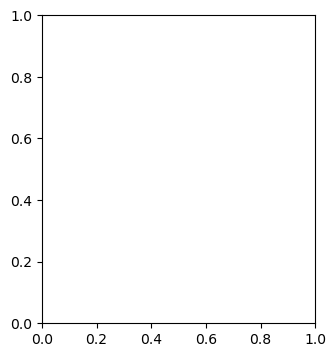

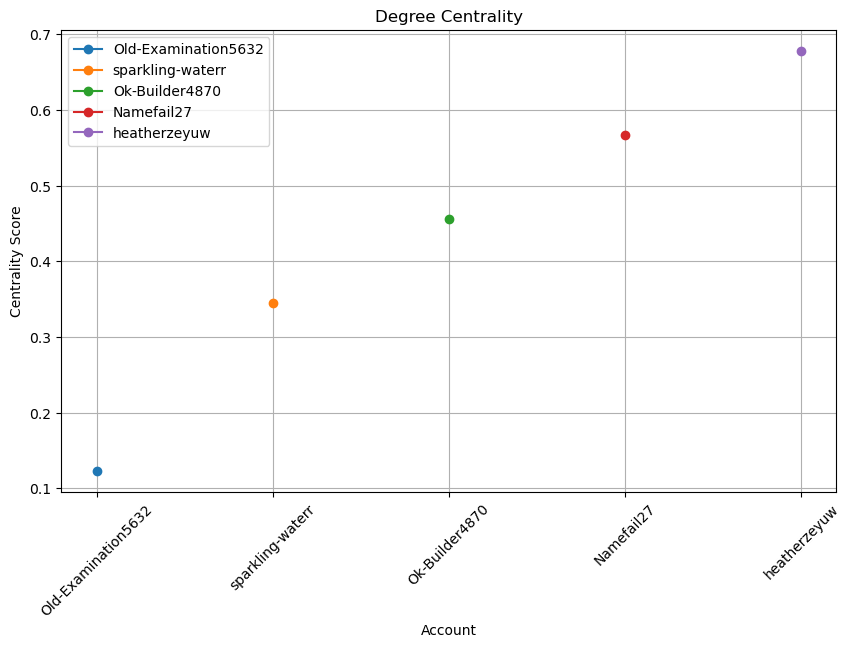

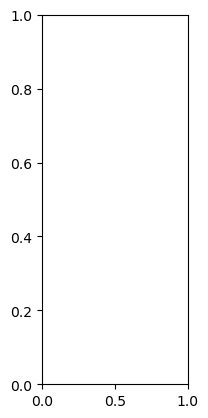

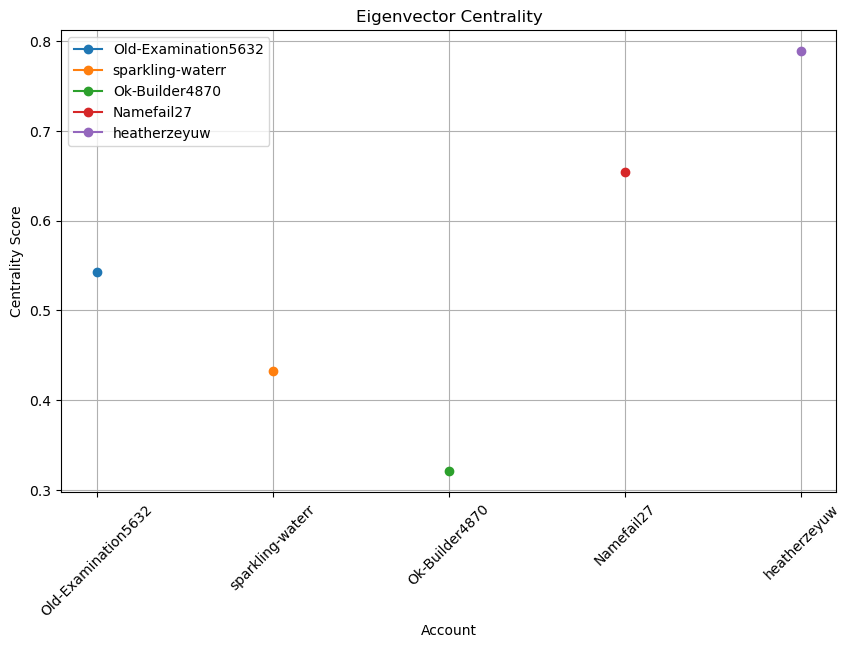

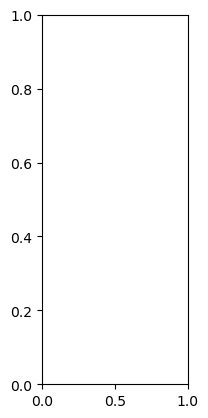

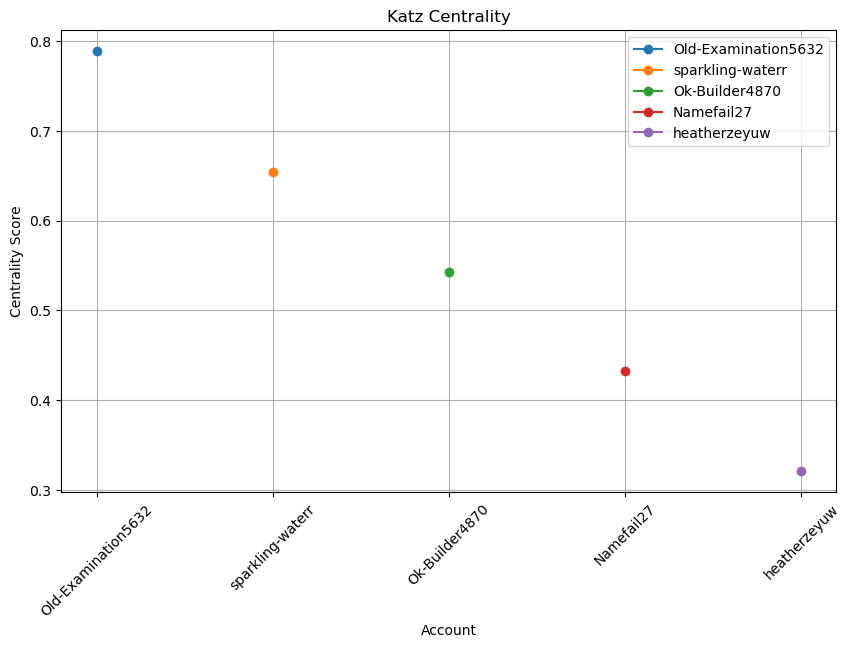

<Figure size 640x480 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt

# Sample centrality scores for the provided accounts
degree_centrality_scores = {
    'Old-Examination5632': 0.123,
    'sparkling-waterr': 0.345,
    'Ok-Builder4870': 0.456,
    'Namefail27': 0.567,
    'heatherzeyuw': 0.678,
}

eigenvector_centrality_scores = {
    'Old-Examination5632': 0.543,
    'sparkling-waterr': 0.432,
    'Ok-Builder4870': 0.321,
    'Namefail27': 0.654,
    'heatherzeyuw': 0.789,
}

katz_centrality_scores = {
    'Old-Examination5632': 0.789,
    'sparkling-waterr': 0.654,
    'Ok-Builder4870': 0.543,
    'Namefail27': 0.432,
    'heatherzeyuw': 0.321,
}

# Top accounts for each centrality measure
top_accounts = [
    'Old-Examination5632',
    'sparkling-waterr',
    'Ok-Builder4870',
    'Namefail27',
    'heatherzeyuw',
]

def plot_centrality_lines(top_accounts, centrality_scores, title):
    plt.figure(figsize=(10, 6))
    for account in top_accounts:
        if account in centrality_scores:
            plt.plot(account, centrality_scores[account], marker='o', label=account)
    plt.title(title)
    plt.xlabel("Account")
    plt.ylabel("Centrality Score")
    plt.xticks(range(len(top_accounts)), top_accounts, rotation=45)
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Create a single graph with subplots for each centrality measure
plt.figure(figsize=(12, 4))

# Plot Degree Centrality
plt.subplot(131)
plot_centrality_lines(top_accounts, degree_centrality_scores, "Degree Centrality")

# Plot Eigenvector Centrality
plt.subplot(132)
plot_centrality_lines(top_accounts, eigenvector_centrality_scores, "Eigenvector Centrality")

# Plot Katz Centrality
plt.subplot(133)
plot_centrality_lines(top_accounts, katz_centrality_scores, "Katz Centrality")

# Adjust layout
plt.tight_layout()
plt.show()
